In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression

from PIL import Image

# constants
repo_path = '/Users/etriesch/dev/tree-finder/'

In [2]:
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 200
print('using device:', device)

using device: cpu


## Helper functions

In [3]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [ ]:
def train_model(model, optimizer, loss_fn, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in tqdm(range(epochs)):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = loss_fn # instantiate the passed loss function
            loss = loss(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t % print_every == 0):
                # print(f'Iteration {t}, loss = {loss.item():0.4}')
                acc = check_accuracy(loader_val, model)
    return acc

In [374]:
# make dataset
SCALE = 1024
CROP = SCALE
SCALE_TEMP = 32 # for training

# define transformations
transform = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), 
                       T.Resize(SCALE_TEMP), 
                       T.ToTensor()])


# create dataset
treeds = dset.ImageFolder(root=repo_path + 'data/images', transform=transform)

In [272]:
# make dataloaders
PCT_TRAIN, PCT_VAL = 0.75, 0.15
N = len(treeds)
num_train = int(N * PCT_TRAIN)
num_val = int(N * PCT_VAL)
num_test = N - num_train - num_val
print('(train, val, test):', num_train, num_val, num_test)


loader_train = DataLoader(treeds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train)))
loader_val = DataLoader(treeds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train, num_train+num_val)))
loader_test = DataLoader(treeds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train+num_val, N)))

(train, val, test): 1238 247 166


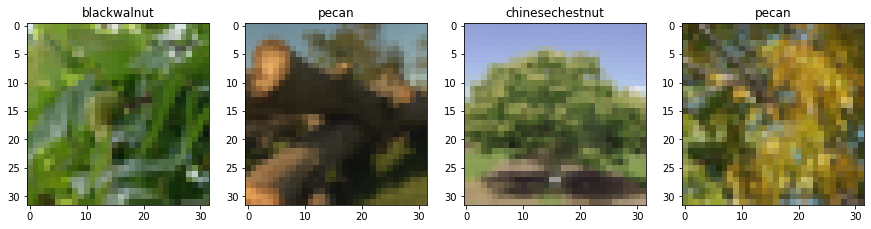

In [273]:
# visualize images
loader = DataLoader(dataset=treeds, batch_size=4, shuffle=True)

trainiter = iter(loader)
imgs, labels = trainiter.next()

# print(type(imgs), type(labels))
show_image_batch(imgs, title=[treeds.classes[x] for x in labels])

## Baseline models

In [274]:
NUM_CLASSES = 7

### Random guessing

In [275]:
mr_random = 1 / NUM_CLASSES
print(mr_random)

0.14285714285714285


### KNN

In [327]:
# helper functions
top_k_accuracy_set = metrics.make_scorer(metrics.top_k_accuracy_score, k=1)
precision_set = metrics.make_scorer(metrics.precision_score, average=None)
scoring = {'accuracy': 'accuracy',
#            'top_5_accuracy':top_k_accuracy_set,
#            'precision': precision_set,
#            'recall': 'recall'
          }

def run_cv(X, y, estimator, params, scoring):
    # run grid search for hyperparameters
    grid_search = GridSearchCV(
                estimator=estimator, 
                param_grid=params,
                scoring=scoring,
                cv=2,
                refit=False)

    cv = grid_search.fit(X, y)

    return cv.cv_results_

In [353]:
# get data
loader_all = DataLoader(treeds, batch_size=num_train+num_val, 
                        sampler=sampler.SubsetRandomSampler(range(0, num_train+num_val)))
X  = flatten(next(iter(loader_all))[0]).numpy()
y = next(iter(loader_all))[1].numpy()

/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [354]:
k_range = range(5, 200, 5)
params={'n_neighbors': k_range}
cv_mean = run_cv(X, y, KNeighborsClassifier(), params, scoring)

In [355]:
mr_knn = cv_mean['mean_test_accuracy'].min()
print(mr_knn)

0.15487950430432462


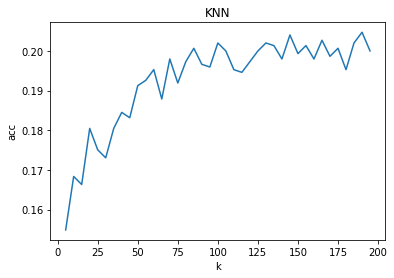

In [356]:
# plot results
plt.plot(k_range, cv_mean['mean_test_accuracy'])

xlab, ylab, title = 'k', 'acc', 'KNN'
plt.xlabel(xlab), plt.ylabel(ylab), plt.title(title)
plt.show()

#### Logistic

In [366]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
params={'penalty': ['l2'], #'l1', 'elasticnet', 'none'
        'C': [1, 10]}

cv_mean = run_cv(X_scaled, y, LogisticRegression(random_state=1, solver='sag'), params, scoring)

/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [358]:
mr_log = cv_mean['mean_test_accuracy'].min()
print(mr_log)

0.16699437336071077


### Logistic regression

In [385]:
hidden_layer_size = 128
learning_rate = 5e-3

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * SCALE_TEMP * SCALE_TEMP, NUM_CLASSES)
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_model(model, optimizer, nn.CrossEntropyLoss(), epochs=10)
# FOR SVM: MultiLabelMarginLoss

Iteration 0, loss = 1.942
Got 0 / 247 correct (0.00)



/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Iteration 0, loss = 2.26
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.351
Got 25 / 247 correct (10.12)

Iteration 0, loss = 1.883
Got 27 / 247 correct (10.93)

Iteration 0, loss = 1.359
Got 48 / 247 correct (19.43)

Iteration 0, loss = 2.822
Got 24 / 247 correct (9.72)

Iteration 0, loss = 1.926
Got 44 / 247 correct (17.81)

Iteration 0, loss = 1.507
Got 51 / 247 correct (20.65)

Iteration 0, loss = 1.508
Got 63 / 247 correct (25.51)

Iteration 0, loss = 1.264
Got 40 / 247 correct (16.19)



0.16194331983805668

### Fully connected single layer

In [ ]:
hidden_layer_size = 128
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * SCALE_TEMP * SCALE_TEMP, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, NUM_CLASSES),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_model(model, optimizer, F.cross_entropy, epochs=10)

Iteration 0, loss = 1.94
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.761
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.566
